In [1]:
%matplotlib inline
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
from scipy import ndimage
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')

### Real(ish) World Example
#### Creating a active transit priority index for Oakland

Please borrow and improve on the code! <br>
It is set up to run with minimal input from the user. <br>
It uses census shapefiles, crash data from TIMS, and census demographic information.

#### Set Geography for Analysis

Start by selecting the spatial information for the Census block group. <br>
Start by Downloading Geography <br>
Files are from Census

In [2]:
census_places = gpd.read_file("Spatial Files/tl_2019_06_place.shp")
block_gr = gpd.read_file("Spatial Files/tl_2019_06_bg.shp")

In [3]:
# Start by selecting Oakland from places file using name

place = census_places[census_places['NAME'] == 'Oakland']

In [4]:
#Select block groups in Alameda County.
block_gr=block_gr[block_gr['COUNTYFP'] == '001']

In [5]:
# Use overlay function to select only for Census Block groups inside of Oakland

bl_gr = gpd.overlay(place, block_gr, how = "intersection")

In [6]:
# GeoID_2 represents the block group code

bl_gr.head()

STATEFP PLACEFP   PLACENS    GEOID     NAME      NAMELSAD LSAD CLASSFP  \
0      06   53000  02411292  0653000  Oakland  Oakland city   25      C1   
1      06   53000  02411292  0653000  Oakland  Oakland city   25      C1   
2      06   53000  02411292  0653000  Oakland  Oakland city   25      C1   
3      06   53000  02411292  0653000  Oakland  Oakland city   25      C1   
4      06   53000  02411292  0653000  Oakland  Oakland city   25      C1   

  PCICBSA PCINECTA                        ...                          \
0       Y        N                        ...                           
1       Y        N                        ...                           
2       Y        N                        ...                           
3       Y        N                        ...                           
4       Y        N                        ...                           

  BLKGRPCE       GEOID_2     NAMELSAD_2  MTFCC_2 FUNCSTAT_2   ALAND_2  \
0        0  060019900000  Block Group 0    G5030          S         0   
1        4  060014090004  Block Group 4    G5030          S  10651357   
2        2  060014090002  Block Group 2    G5030          S   3906148   
3        1  060014100001  Block Group 1    G5030          S   2537900   
4        3  060014090003  Block Group 3    G5030          S   1060501   

    AWATER_2   INTPTLAT_2    INTPTLON_2  \
0  139280186  +37.6836979  -122.2281492   
1    2641017  +37.7118542  -122.2178896   
2    1748425  +37.7529267  -122.2106011   
3     145283  +37.7352689  -122.1283133   
4          0  +37.7311264  -122.1944159   

                                            geometry  
0  POLYGON ((-122.256282 37.721077, -122.234182 3...  
1  POLYGON ((-122.234182 37.70702, -122.256282 37...  
2  POLYGON ((-122.226174 37.745402, -122.2266 37....  
3  POLYGON ((-122.125345 37.729636, -122.127423 3...  
4  POLYGON ((-122.2006 37.729099, -122.200316 37....  

[5 rows x 29 columns]

In [7]:
# Make a simple copy of the bl_gr file that retains id and geography

bl_simp = bl_gr[['GEOID_2','geometry']].reset_index()
place_simp = place[['NAME','geometry']]

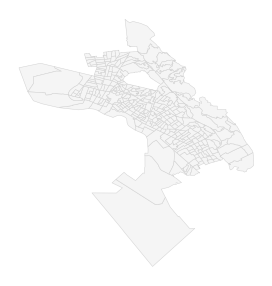

In [8]:
# See what we have

bl_simp.plot(figsize = (5, 5), color = "whitesmoke", edgecolor = "lightgrey", linewidth = 0.5).set_axis_off()

#### Attach Geospatial Data - Ped and Bike Crashes
This part of the code loads and cleans crash data from TIMS. <br>
The crashes are for 5 years of data for Oakland.

In [9]:
ped_cr = gpd.read_file("Spatial Files/oakland_ped_collisions.shp")
bike_cr = gpd.read_file("Spatial Files/oakland_bike_collisions.shp")

In [10]:
# Create smaller simpler dataframe
# Saving Case_ID, Crash Severity, and geometry
# Crash severity is in the column labelled "COLLISIO_1

ped_cr_sh = ped_cr[['CASE_ID','COLLISIO_1','geometry']]
ped_cr_sh = ped_cr_sh.rename(columns={"CASE_ID": "ped_ID", "COLLISIO_1": "ped_sev"})
ped_cr_sh['count_ped'] = 1
bike_cr_sh = bike_cr[['CASE_ID','COLLISIO_1','geometry']]
bike_cr_sh = bike_cr_sh.rename(columns={"CASE_ID": "bike_ID", "COLLISIO_1": "bike_sev"})
bike_cr_sh['count_bike'] = 1

In [11]:
ped_cr_sh.head()

ped_ID  ped_sev                                     geometry  count_ped
0  5814965        4   POINT (6048140.62245257 2127808.959896133)          1
1  5890183        4   POINT (6071092.90250935 2105101.852423229)          1
2  5907930        3   POINT (6066516.973158794 2117245.90766302)          1
3  5910013        1  POINT (6047576.210446283 2120306.492547903)          1
4  5910068        1   POINT (6066158.12061711 2104118.418187424)          1

In [12]:
# The block data didn't have a projection associated with it, let's add the projection used by the census
bl_simp.crs = {'init' :'epsg:4326'}
bl_simp.crs

{'init': 'epsg:4326'}

In [13]:
# Reproject census block group data into the same projection as the pedestrian and bike crash data
bl_proj = bl_simp.to_crs(ped_cr_sh.crs)

In [14]:
# Do the same thing for the place shapefile
place_simp.crs = {'init' :'epsg:4326'}
place_proj = place_simp.to_crs(ped_cr_sh.crs)

In [15]:
# Remove crashes that are outside of Oaklands borders
bike_cr_sh = gpd.sjoin(bike_cr_sh, place_proj, how = 'inner').drop(columns = ['NAME','index_right'])

In [16]:
# Remove crashes that are outside of Oaklands borders

ped_cr_sh = gpd.sjoin(ped_cr_sh, place_proj, how = 'inner').drop(columns = ['NAME','index_right'])

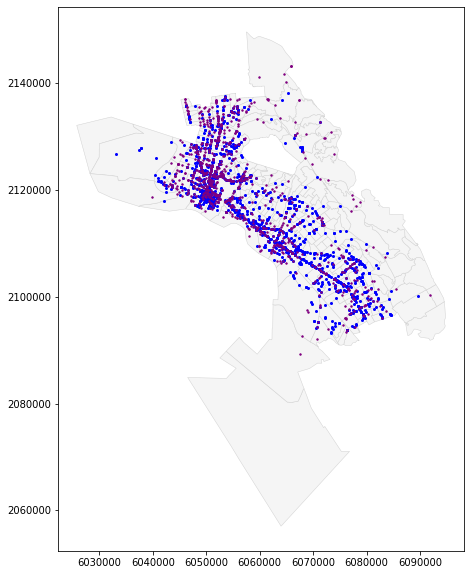

In [19]:
# Plot what we have

base = bl_proj.plot(figsize = (10, 10), color = "whitesmoke", edgecolor = "lightgrey", linewidth = 0.5)
ped_cr_sh.plot(ax =base, markersize=4, color = 'Blue')
bike_cr_sh.plot(ax =base, markersize=2, color = 'Purple')

### ACTION STEP - 1
#### Determine Distance Consideration
How close should a crash be to a block group to be considered an impact on residents?<br/>
We can use buffering to change the area under consideration. 

In [22]:
# We can look at the CRS to determine the projection being used and the scale for measurements.
# We are using us-ft. See: http://prj2epsg.org/epsg/2227

ped_cr_sh.crs

{'init': 'epsg:2227'}

#### ACTION STEP IS HERE
How close to a block group should be a crash be for us to consider it
an impact on them? <br>
You decide? (Remember we are measuring in feet)

In [21]:
ped_buffer = 5280/2
bike_buffer = (5280)

In [23]:
ped_cr_sh['geometry'] = ped_cr_sh['geometry'].buffer(ped_buffer)
bike_cr_sh['geometry'] = bike_cr_sh['geometry'].buffer(bike_buffer)

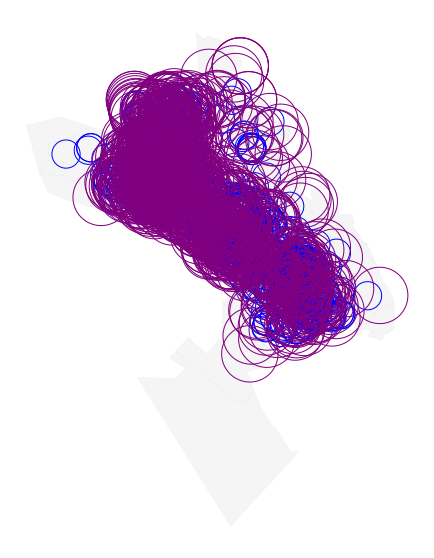

In [25]:
# See what we created
# Circles show the "influence" areas for crashes

base = bl_proj.plot(figsize = (10, 10), color = "whitesmoke", edgecolor = "lightgrey", linewidth = 0.1)
ax = ped_cr_sh.plot(ax =base, facecolor = "none", edgecolor = "Blue")
bike_cr_sh.plot(ax =base, facecolor = "none", edgecolor = "Purple").set_axis_off()

### ACTION STEP - 2
#### Weight crashes by severity
We are now going to create a metric based on the severity of the crashes. <br>
How should we compare more or less severe crashes. Not all crashes are equal <br>
but how should we compare them to create a composite score?

There are four types of severities in the dataset (note Property Damage Only crashes are not included).

##### What severity should be given to each crash

In [26]:
# You decide... the default gives fatal and severe crashes twice as much weight.

fatal = 2
severe = 2
visible = 1
comp_pain = 1

##### You can ignore this part of the code if you would like...
It is creating the weighted score.

In [27]:
# This part of the code adds a severity weight column

ped_cr_sh['p_sev_wt'] = 1
ped_cr_sh['p_sev_wt'][ped_cr_sh['ped_sev'] == 1] = fatal
ped_cr_sh['p_sev_wt'][ped_cr_sh['ped_sev'] == 2] = severe
ped_cr_sh['p_sev_wt'][ped_cr_sh['ped_sev'] == 3] = visible
ped_cr_sh['p_sev_wt'][ped_cr_sh['ped_sev'] == 4] = comp_pain

bike_cr_sh['b_sev_wt'] = 1
bike_cr_sh['b_sev_wt'][bike_cr_sh['bike_sev'] == 1] = fatal
bike_cr_sh['b_sev_wt'][bike_cr_sh['bike_sev'] == 2] = severe
bike_cr_sh['b_sev_wt'][bike_cr_sh['bike_sev'] == 3] = visible
bike_cr_sh['b_sev_wt'][bike_cr_sh['bike_sev'] == 4] = comp_pain

In [28]:
# Join crashes to block groups. Sjoin will create a location record for each overlap of a crash buffer and the block group

bl_ped = gpd.sjoin(bl_proj, ped_cr_sh, how = 'left').drop(columns = ['index_right'])
bl_bike = gpd.sjoin(bl_proj, bike_cr_sh, how = 'left').drop(columns = ['index_right'])

In [29]:
# Summarizes the data into tables organized by block group.

bl_sum_ped = bl_ped.groupby(['GEOID_2'])['count_ped','p_sev_wt'].sum().reset_index()
bl_sum_bike = bl_bike.groupby(['GEOID_2'])['count_bike','b_sev_wt'].sum().reset_index()

In [30]:
# Joins the data into a single table.

bl_analysis = bl_sum_ped.merge(bl_sum_bike, on = 'GEOID_2')
bl_analysis = bl_simp.merge(bl_analysis, on = 'GEOID_2')

#### Fun with Maps!!!
Python maps are not a pretty as what you can make in other programs...
BUT you can make a lot of maps really quickly. The code below creates <br>
a map based on the information in each column in the list.
Feel free to speal the code to generate your own maps.

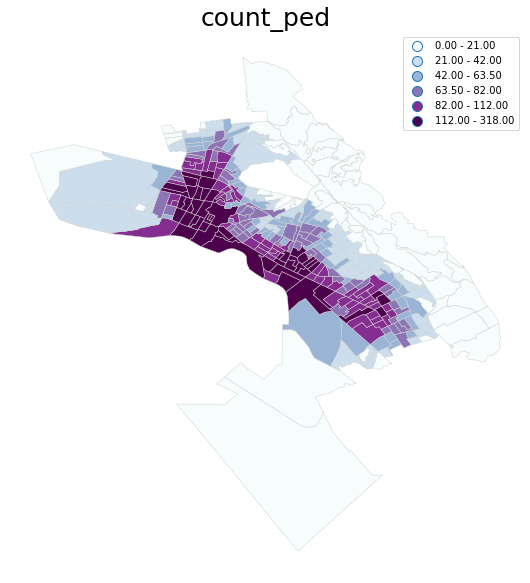

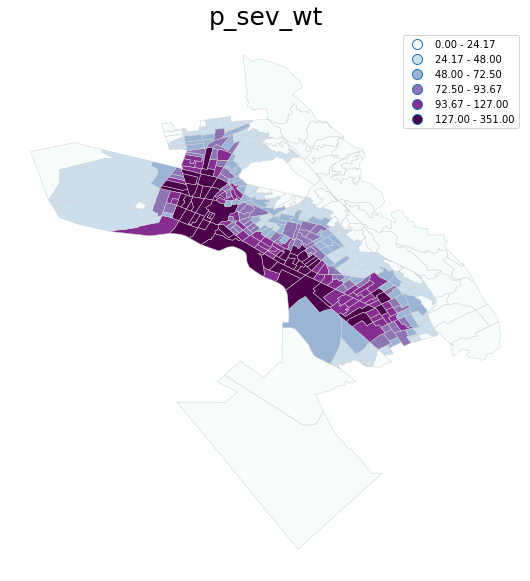

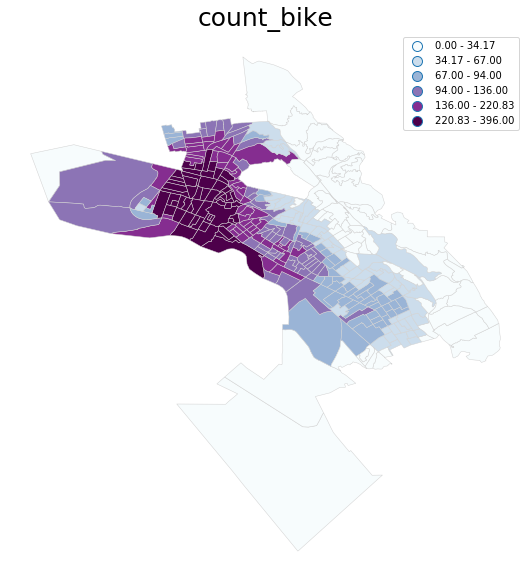

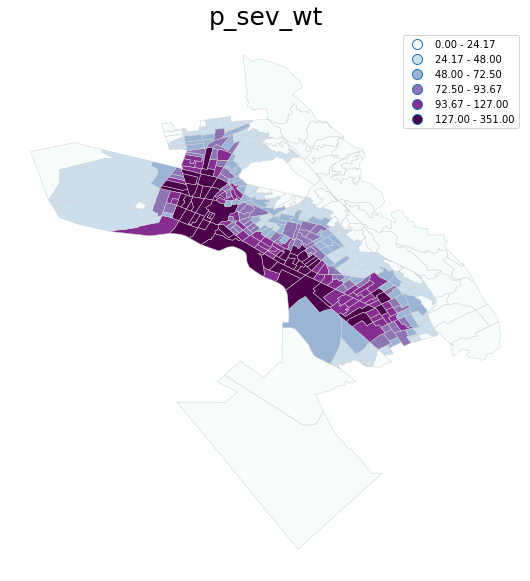

In [40]:
for x in ['count_ped', 'p_sev_wt','count_bike','p_sev_wt']:
    ax = bl_analysis.plot(figsize = (10, 10), scheme = "quantiles", k = 6, column = x, cmap = "BuPu",edgecolor = "lightgrey", linewidth = 0.5, legend = True)
    ax.set_axis_off()
    ax.set_title(x, fontsize=25)

#### Normalizing the data
For our purposes we will want to normalize the variables summarizing the crash data. <br>
This will allow us to more easily factor the results into a composite index in the next step.

In [32]:
# Create scores normalized as percent of highest value
bl_analysis['c_ped_perc'] = bl_analysis['count_ped']/bl_analysis['count_ped'].max()
bl_analysis['sev_ped_perc'] = bl_analysis['p_sev_wt']/bl_analysis['p_sev_wt'].max()
bl_analysis['c_bike_perc'] = bl_analysis['count_bike']/bl_analysis['count_bike'].max()
bl_analysis['sev_bike_perc'] = bl_analysis['b_sev_wt']/bl_analysis['b_sev_wt'].max()

### Add Census Information
This step brings in census data that we've downloaded from social explorer and done some minor <br>
cleaning. It includes a set of variables described in a table we've hopefully provided to you for <br>
the lab (fingers crossed).

In [33]:
indices = pd.read_csv("alamedacounty_mostly_computed_indices.csv")

In [34]:
indices.columns

Index(['Geo_FIPS', 'Geo_GEOID', 'Geo_NAME', 'Geo_QName', 'Geo_STUSAB',
       'Geo_SUMLEV', 'Geo_GEOCOMP', 'Geo_FILEID', 'Geo_LOGRECNO', 'Geo_US',
       'Geo_REGION', 'Geo_DIVISION', 'Geo_STATECE', 'Geo_STATE', 'Geo_COUNTY',
       'Geo_COUSUB', 'Geo_PLACE', 'Geo_PLACESE', 'Geo_TRACT', 'Geo_BLKGRP',
       'avg.hh.size', 'coc.population', 'total.population',
       'elderly.population', 'households', 'limited.english.households',
       'poverty.population', 'pop.poverty.determined', 'single.parent.fam',
       'families', 'youth.population', 'occupied.housing.units',
       'zero.vehicle.hh', 'coc.population.pct', 'elderly.population.pct',
       'limited.english.households.pct', 'poverty.population.pct',
       'single.parent.fam.pct', 'youth.population.pct', 'zero.vehicle.hh.pct',
       'coc.pop.norm', 'elderly.pop.norm', 'limited.english.households.norm',
       'poverty.population.norm', 'single.parent.fam.norm',
       'youth.population.norm', 'zero.vehicle.hh.norm'],
      dty

##### Join the table to our work from above based on the block group
We've also included some work to drop columns that are not necessary to keep things more clean.

In [35]:
bl_analysis['join_id'] = bl_analysis['GEOID_2']

In [36]:
indices['join_id'] = indices['Geo_GEOID'].str[7:]

In [37]:
bl_analysis = bl_analysis.merge(indices, on = 'join_id').drop(columns = ['join_id', 'Geo_FIPS', 'Geo_GEOID', 'Geo_NAME', 'Geo_QName',
       'Geo_STUSAB', 'Geo_SUMLEV', 'Geo_GEOCOMP', 'Geo_FILEID', 'Geo_LOGRECNO',
       'Geo_US', 'Geo_REGION', 'Geo_DIVISION', 'Geo_STATECE', 'Geo_STATE',
       'Geo_COUNTY', 'Geo_COUSUB'])

##### Let's look at what we have!
We are going to use that same mapping code from before to see what the variables look like.

In [38]:
bl_analysis.columns

Index(['index', 'GEOID_2', 'geometry', 'count_ped', 'p_sev_wt', 'count_bike',
       'b_sev_wt', 'c_ped_perc', 'sev_ped_perc', 'c_bike_perc',
       'sev_bike_perc', 'Geo_PLACE', 'Geo_PLACESE', 'Geo_TRACT', 'Geo_BLKGRP',
       'avg.hh.size', 'coc.population', 'total.population',
       'elderly.population', 'households', 'limited.english.households',
       'poverty.population', 'pop.poverty.determined', 'single.parent.fam',
       'families', 'youth.population', 'occupied.housing.units',
       'zero.vehicle.hh', 'coc.population.pct', 'elderly.population.pct',
       'limited.english.households.pct', 'poverty.population.pct',
       'single.parent.fam.pct', 'youth.population.pct', 'zero.vehicle.hh.pct',
       'coc.pop.norm', 'elderly.pop.norm', 'limited.english.households.norm',
       'poverty.population.norm', 'single.parent.fam.norm',
       'youth.population.norm', 'zero.vehicle.hh.norm'],
      dtype='object')

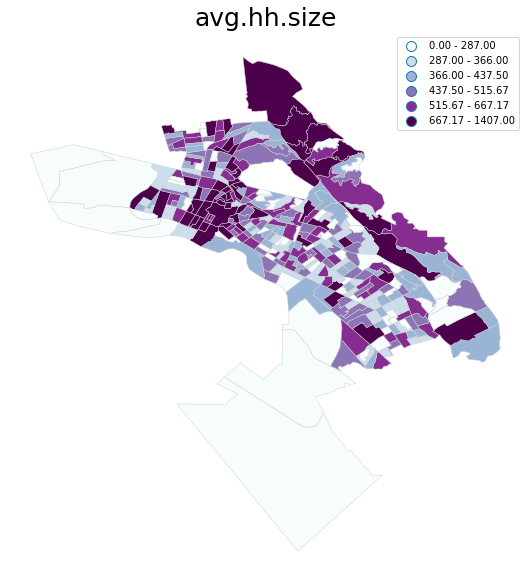

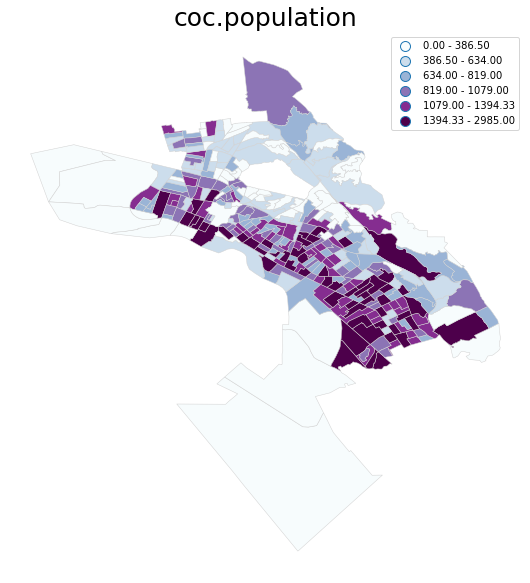

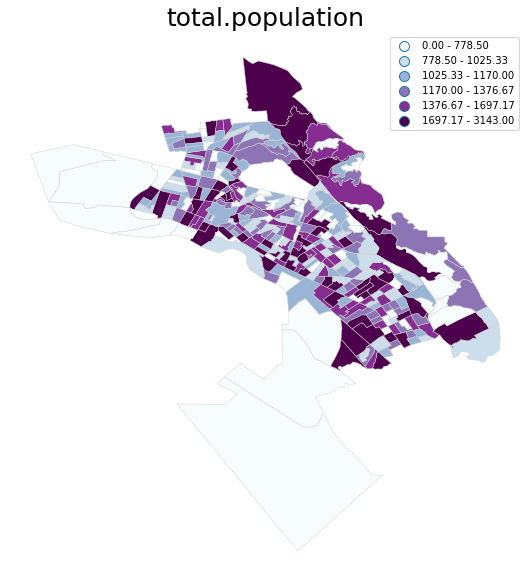

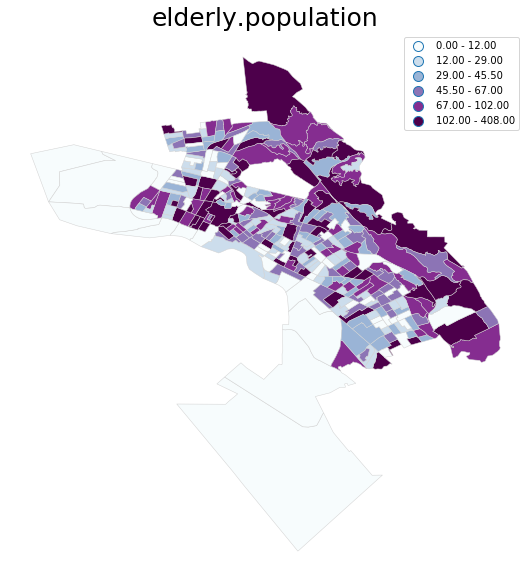

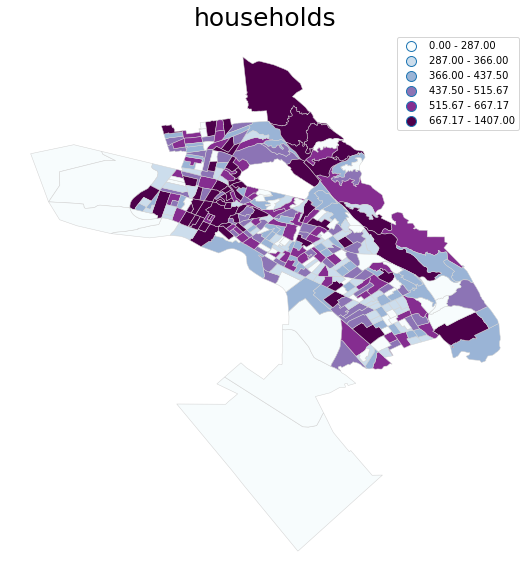

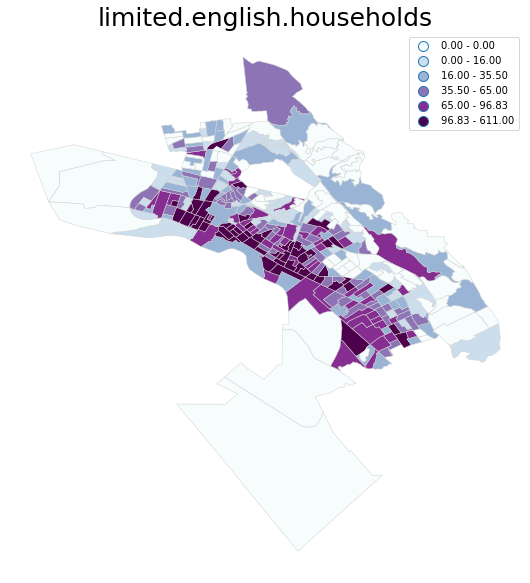

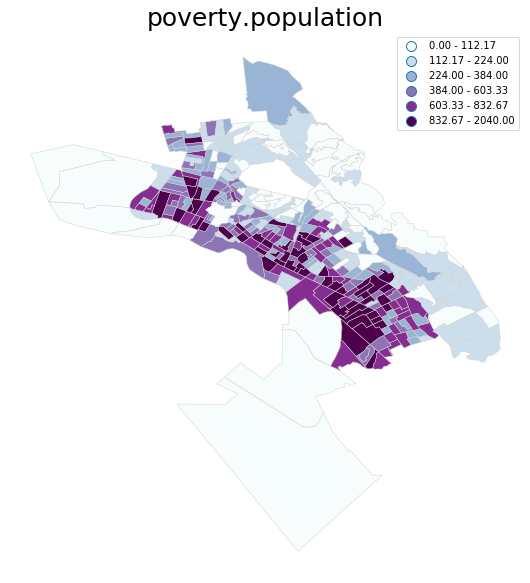

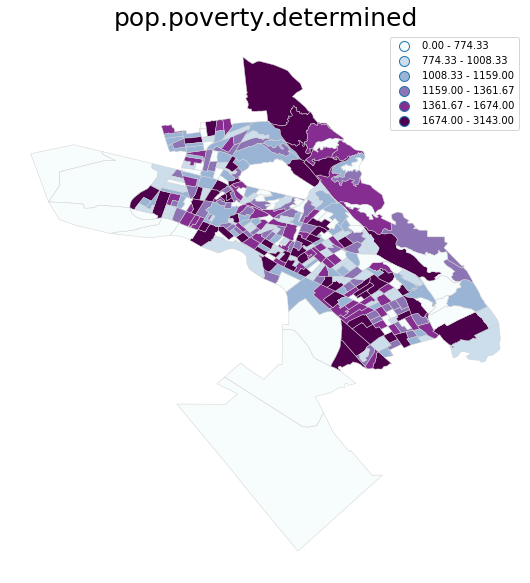

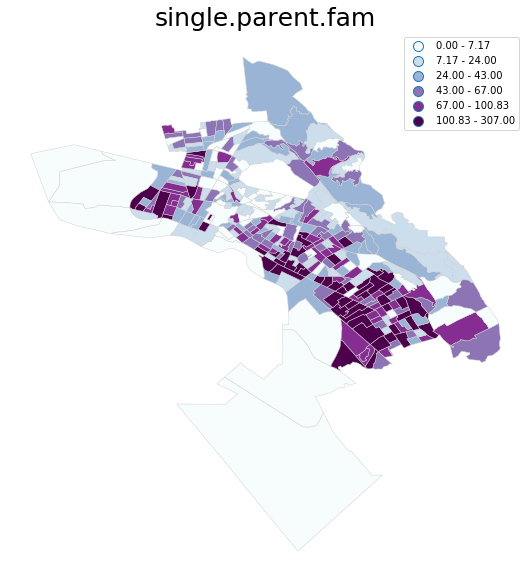

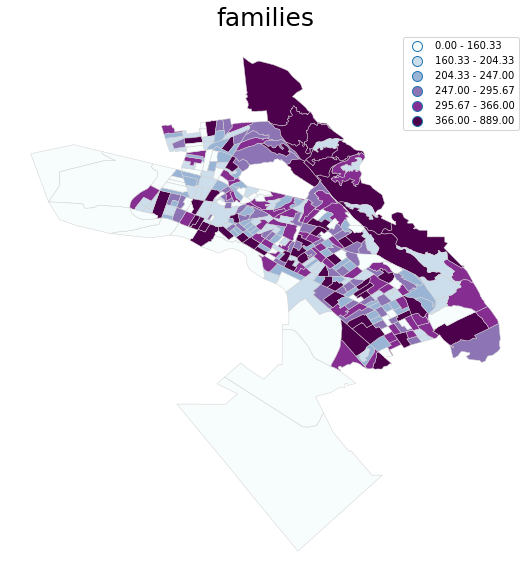

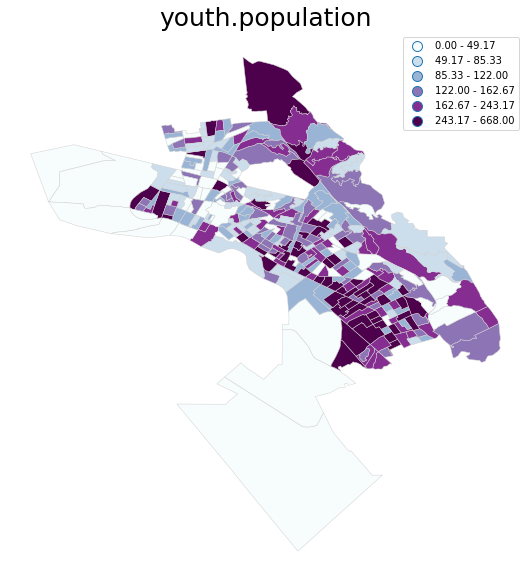

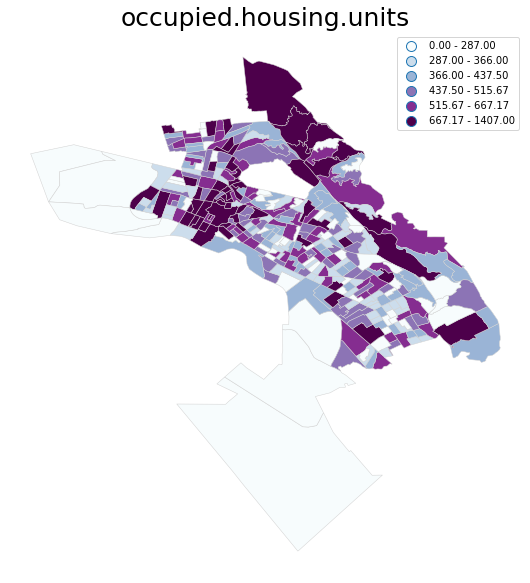

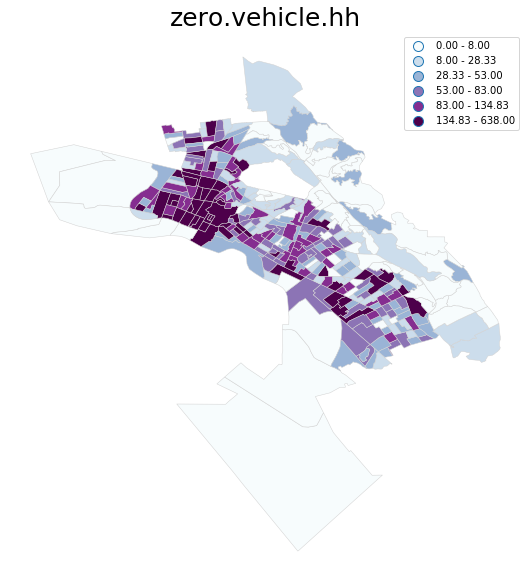

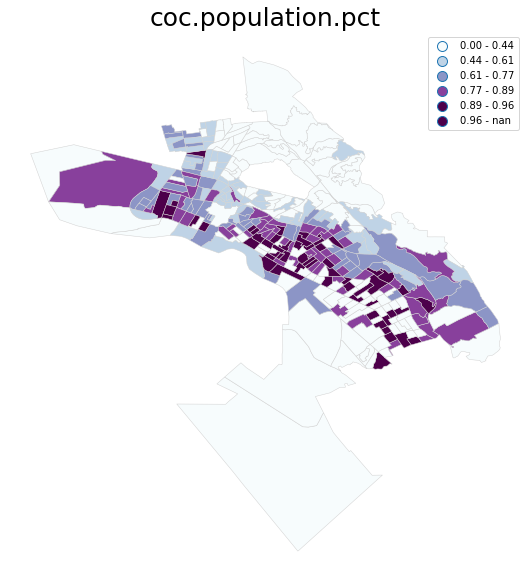

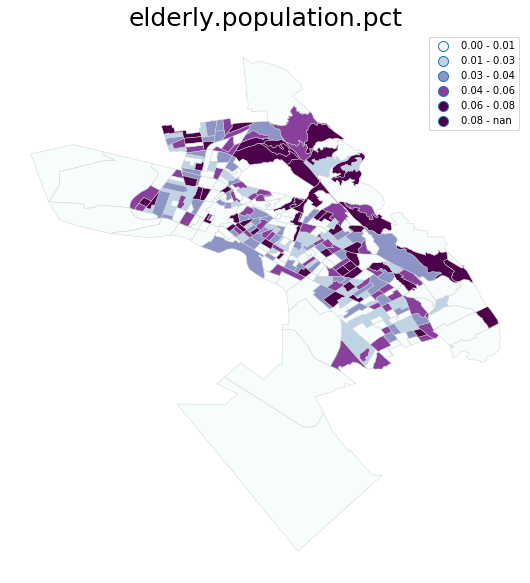

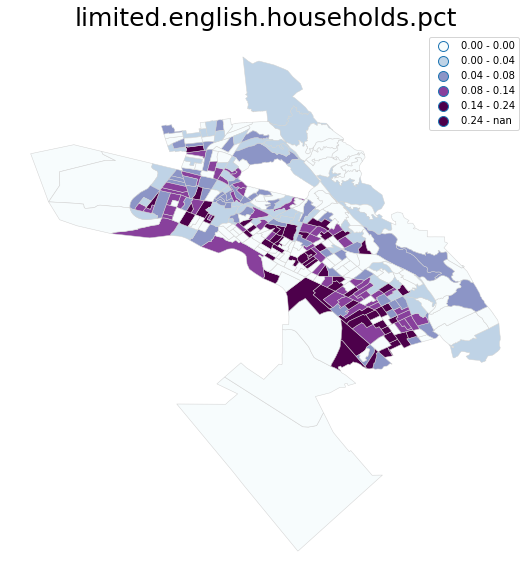

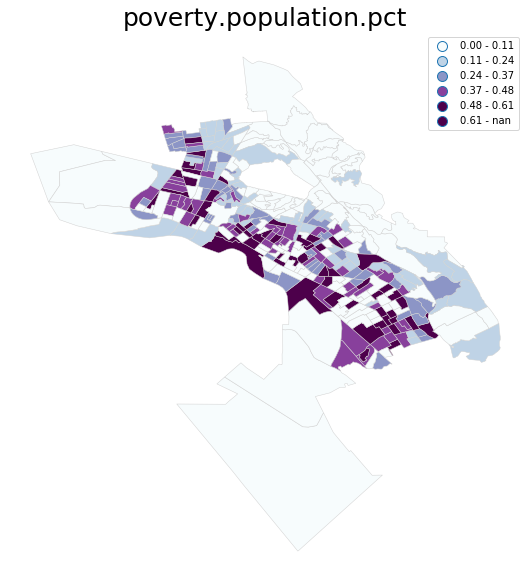

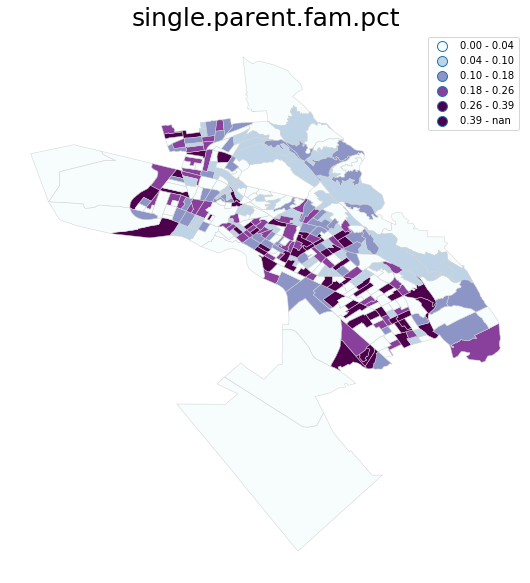

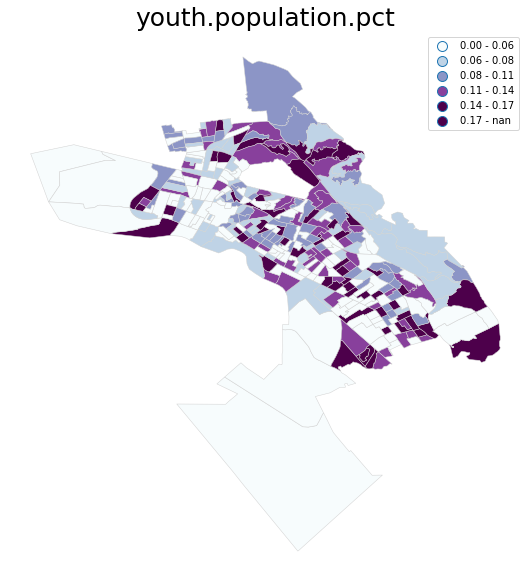

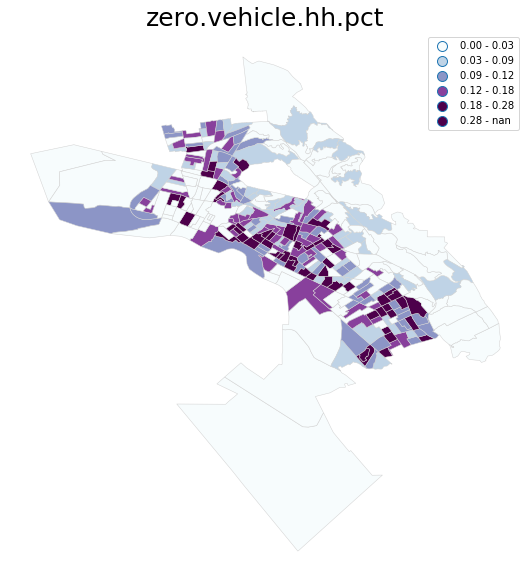

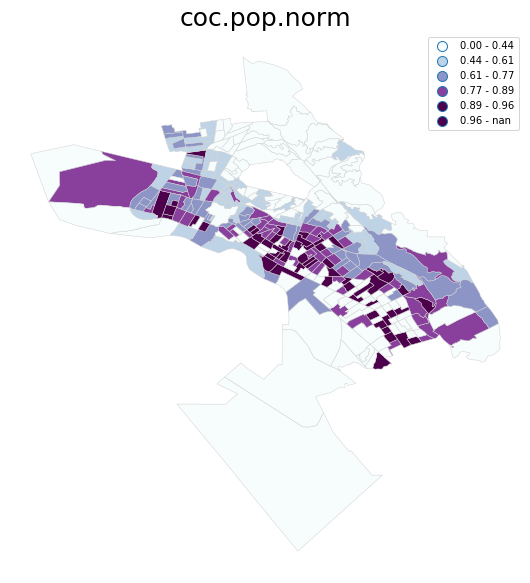

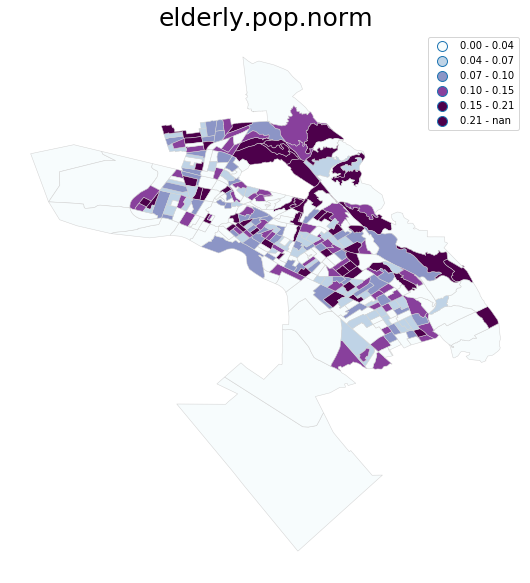

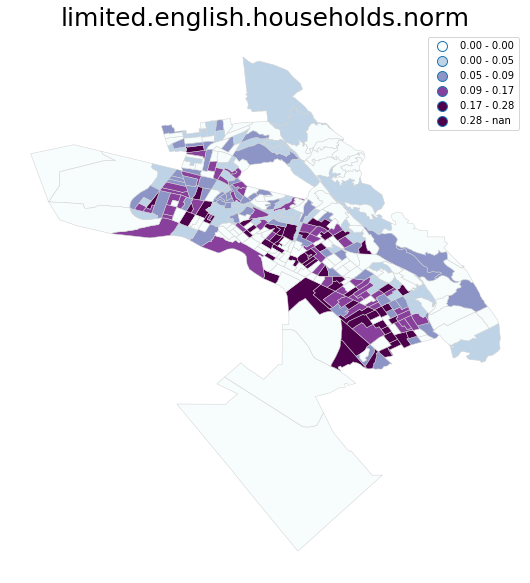

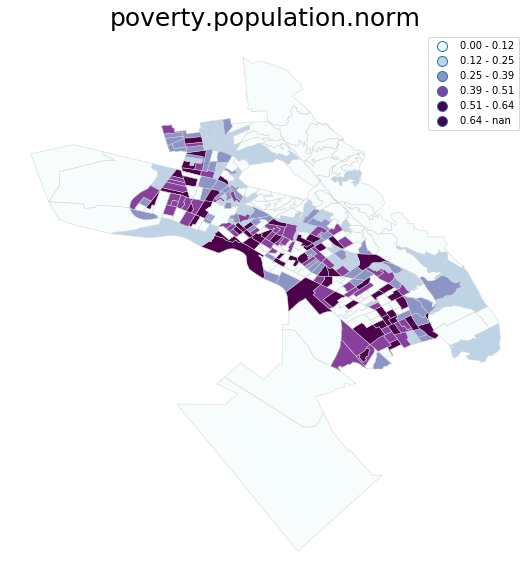

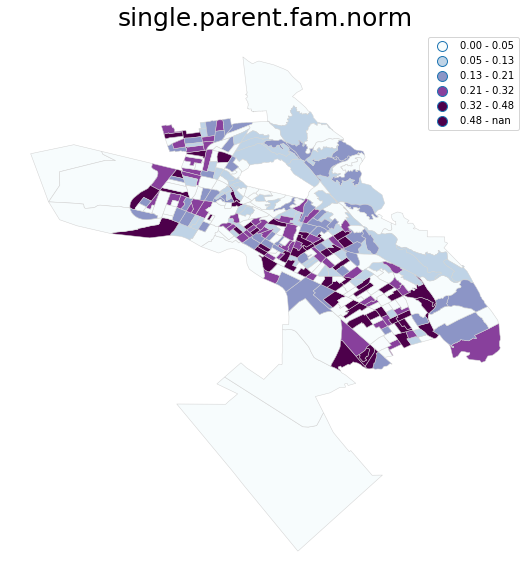

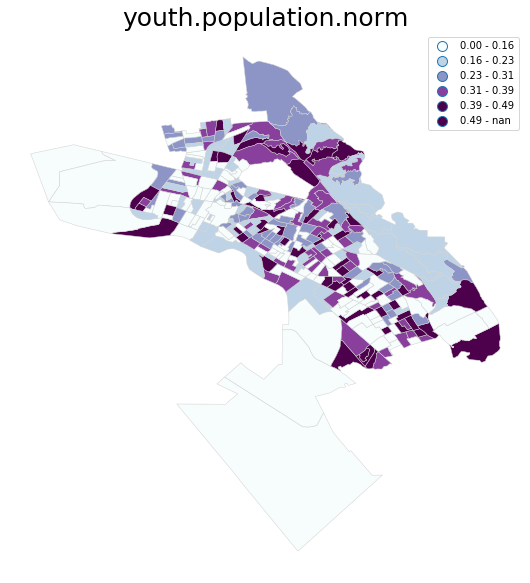

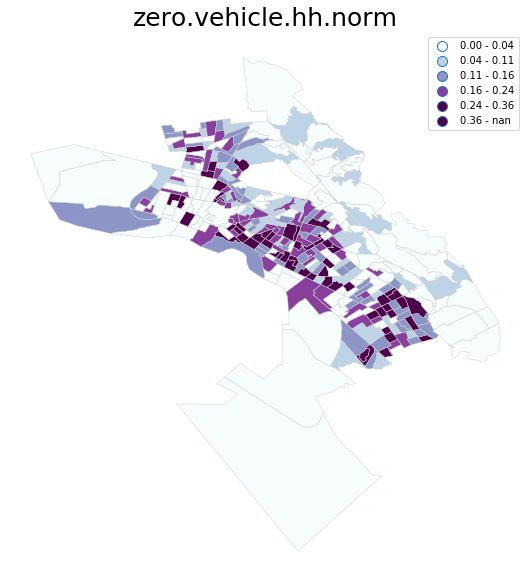

In [41]:
for x in ['avg.hh.size', 'coc.population', 'total.population',
       'elderly.population', 'households', 'limited.english.households',
       'poverty.population', 'pop.poverty.determined', 'single.parent.fam',
       'families', 'youth.population', 'occupied.housing.units',
       'zero.vehicle.hh', 'coc.population.pct', 'elderly.population.pct',
       'limited.english.households.pct', 'poverty.population.pct',
       'single.parent.fam.pct', 'youth.population.pct', 'zero.vehicle.hh.pct',
       'coc.pop.norm', 'elderly.pop.norm', 'limited.english.households.norm',
       'poverty.population.norm', 'single.parent.fam.norm',
       'youth.population.norm', 'zero.vehicle.hh.norm']:
    ax = bl_analysis.plot(figsize = (10, 10), scheme = "quantiles", k = 6, column = x, cmap = "BuPu",edgecolor = "lightgrey", linewidth = 0.5, legend = True)
    ax.set_axis_off()
    ax.set_title(x, fontsize=25)

### ACTION STEP - 3
#### Where should we prioritize active transit investments?
We have all the data. But now the hard questions... <br>
What factors should we consider to prioritize resources. <br>
We included three starter indecise: (1) Crash Only, (2) Census Factors Only, (3) Simple All Factors.
They are not that good. Make us something better... whatever that means. <br>
Go down to indecis 4 and 5 to start making your own.

#### Create an Index

In [42]:
bl_analysis['index1'] = \
        bl_analysis['c_ped_perc'] * 1 + \
        bl_analysis['sev_ped_perc'] * 1 + \
        bl_analysis['c_bike_perc'] * 1 + \
        bl_analysis['sev_bike_perc'] * 1

In [43]:
bl_analysis['index2'] = \
        bl_analysis['coc.population.pct'] * 1 + \
        bl_analysis['elderly.population.pct'] * 1 + \
        bl_analysis['limited.english.households.pct'] * 1 + \
        bl_analysis['poverty.population.pct'] * 1 + \
        bl_analysis['single.parent.fam.pct'] * 1 + \
        bl_analysis['youth.population.pct'] * 1 + \
        bl_analysis['zero.vehicle.hh.pct'] * 1 + \
        bl_analysis['coc.pop.norm'] * 1 + \
        bl_analysis['elderly.pop.norm'] * 1 + \
        bl_analysis['limited.english.households.norm'] * 1 + \
        bl_analysis['poverty.population.norm'] * 1 + \
        bl_analysis['single.parent.fam.norm'] * 1 + \
        bl_analysis['youth.population.norm'] * 1 + \
        bl_analysis['zero.vehicle.hh.norm'] * 1

In [44]:
bl_analysis['index3'] = \
        bl_analysis['coc.population.pct'] * 1 + \
        bl_analysis['elderly.population.pct'] * 1  + \
        bl_analysis['limited.english.households.pct'] * 1 + \
        bl_analysis['poverty.population.pct'] * 1 + \
        bl_analysis['single.parent.fam.pct'] * 1 + \
        bl_analysis['youth.population.pct'] * 1 + \
        bl_analysis['zero.vehicle.hh.pct'] * 1 + \
        bl_analysis['coc.pop.norm'] * 1  + \
        bl_analysis['elderly.pop.norm'] * 1 + \
        bl_analysis['limited.english.households.norm'] * 1 + \
        bl_analysis['poverty.population.norm'] * 1 + \
        bl_analysis['single.parent.fam.norm'] * 1 + \
        bl_analysis['youth.population.norm'] * 1 + \
        bl_analysis['zero.vehicle.hh.norm'] * 4 + \
        bl_analysis['count_ped']/bl_analysis['count_ped'].max() * 2 + \
        bl_analysis['p_sev_wt']/bl_analysis['p_sev_wt'].max() * 2 + \
        bl_analysis['count_bike']/bl_analysis['count_bike'].max() * 2 + \
        bl_analysis['b_sev_wt']/bl_analysis['b_sev_wt'].max() * 2

##### The easiest way to make your index is to change the weighting factor already in the code
0 is the same as deleting the factor
And... Keep creating if we have actually left enough time for you.

In [45]:
bl_analysis['index4'] = \
        bl_analysis['coc.population.pct'] * 1 + \
        bl_analysis['elderly.population.pct'] * 1  + \
        bl_analysis['limited.english.households.pct'] * 1 + \
        bl_analysis['poverty.population.pct'] * 1 + \
        bl_analysis['single.parent.fam.pct'] * 1 + \
        bl_analysis['youth.population.pct'] * 1 + \
        bl_analysis['zero.vehicle.hh.pct'] * 1 + \
        bl_analysis['coc.pop.norm'] * 1  + \
        bl_analysis['elderly.pop.norm'] * 1 + \
        bl_analysis['limited.english.households.norm'] * 1 + \
        bl_analysis['poverty.population.norm'] * 1 + \
        bl_analysis['single.parent.fam.norm'] * 1 + \
        bl_analysis['youth.population.norm'] * 1 + \
        bl_analysis['zero.vehicle.hh.norm'] * 4 + \
        bl_analysis['count_ped']/bl_analysis['count_ped'].max() * 2 + \
        bl_analysis['p_sev_wt']/bl_analysis['p_sev_wt'].max() * 2 + \
        bl_analysis['count_bike']/bl_analysis['count_bike'].max() * 2 + \
        bl_analysis['b_sev_wt']/bl_analysis['b_sev_wt'].max() * 2

In [46]:
bl_analysis['index5'] = \
        bl_analysis['coc.population.pct'] * 1 + \
        bl_analysis['elderly.population.pct'] * 1  + \
        bl_analysis['limited.english.households.pct'] * 1 + \
        bl_analysis['poverty.population.pct'] * 1 + \
        bl_analysis['single.parent.fam.pct'] * 1 + \
        bl_analysis['youth.population.pct'] * 1 + \
        bl_analysis['zero.vehicle.hh.pct'] * 1 + \
        bl_analysis['coc.pop.norm'] * 1  + \
        bl_analysis['elderly.pop.norm'] * 1 + \
        bl_analysis['limited.english.households.norm'] * 1 + \
        bl_analysis['poverty.population.norm'] * 1 + \
        bl_analysis['single.parent.fam.norm'] * 1 + \
        bl_analysis['youth.population.norm'] * 1 + \
        bl_analysis['zero.vehicle.hh.norm'] * 4 + \
        bl_analysis['count_ped']/bl_analysis['count_ped'].max() * 2 + \
        bl_analysis['p_sev_wt']/bl_analysis['p_sev_wt'].max() * 2 + \
        bl_analysis['count_bike']/bl_analysis['count_bike'].max() * 2 + \
        bl_analysis['b_sev_wt']/bl_analysis['b_sev_wt'].max() * 2

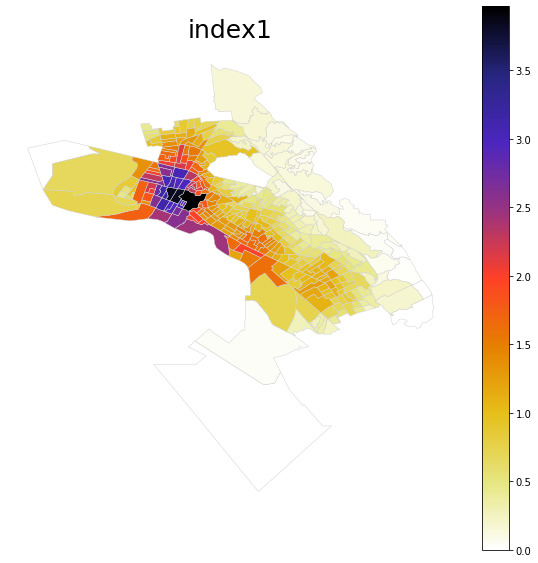

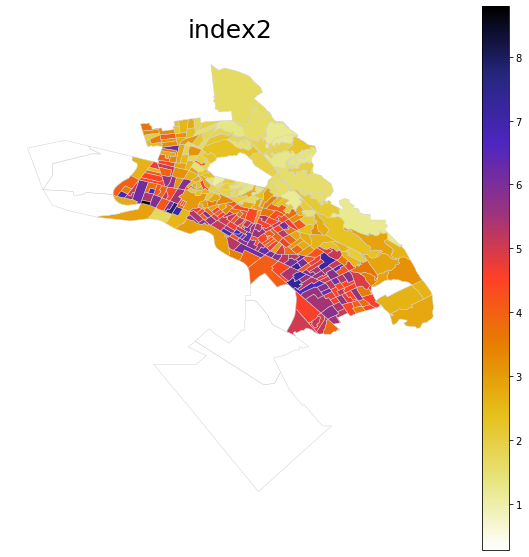

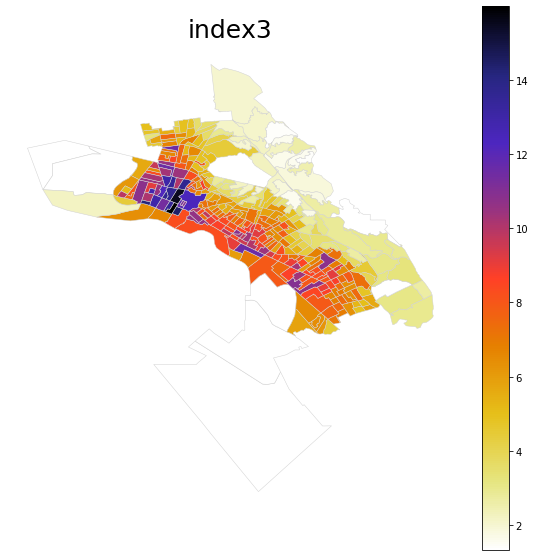

In [47]:
for x in ['index1','index2','index3']:
    ax = bl_analysis.plot(figsize = (10, 10), column = x, cmap = "CMRmap_r",edgecolor = "lightgrey", linewidth = 0.5, legend = True)
    ax.set_axis_off()
    ax.set_title(x, fontsize=25)

### Final Action Item
#### Pick your preferred index and send it to us.
At the end we will put them on the board. <br>
For simplicity just copy the image and email it to us.
